# Kaggle APTOS 2019 Challenge

APTOS 2019 is a challenge hosted by Kaggle where the goal is to classify fundus (eye retina) images of diabetic rethinopatic patients according to the severity of their disease on a scale 0 (minimum severity) to 4 (maximum severity).

This notebook illustrates the model I submitted which achieved a final QWK (Quadratic Weighted Kappa) score of 0.9 (maximum score being 1).

### Load libraries

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../input/efficientnetkeras/efficientnet-master')) # from https://github.com/qubvel/efficientnet

import cv2
import efficientnet.keras as efn
import json
from keras.activations import elu
from keras.callbacks import Callback
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
import tensorflow as tf
from tqdm import tqdm

Using TensorFlow backend.


### Set parameters

In [2]:
batch_size = 32
EN_size = 224
seed = 1990

### Set random seed

In [3]:
random.seed(seed)
tf.set_random_seed(seed)

### Load data

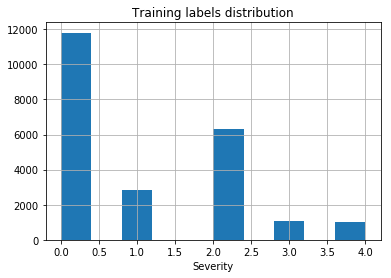

In [6]:
labels_15 = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
labels_15.rename(columns={"image": "id_code", "level": "diagnosis"}, inplace=True)
labels_15['path'] = '../input/diabetic-retinopathy-resized/resized_train/resized_train' + '/' + labels_15['id_code'] + '.jpeg'

idx = labels_15[labels_15['diagnosis']==0].index.to_list()
idx = random.sample(idx, k=len(idx)-10000) # cut class 0 examples for more balance and to reduce training time
labels_15.drop(idx, inplace=True)

labels_19 = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
labels_19['path'] = '../input/aptos2019-blindness-detection/train_images' + '/' + labels_19['id_code'] + '.png'

train_df = pd.concat([labels_15, labels_19])

train_df['diagnosis'].hist()
plt.title('Training labels distribution')
plt.xlabel('Severity')
train_df['diagnosis'].value_counts()

x = train_df[['path']]
y = train_df['diagnosis']

### Function to open and resize images

In [5]:
def preprocess_image(path):
    img = Image.open(path)
    img = img.resize((EN_size, EN_size), resample=Image.LANCZOS)
    return img

### Show some sample images for each class

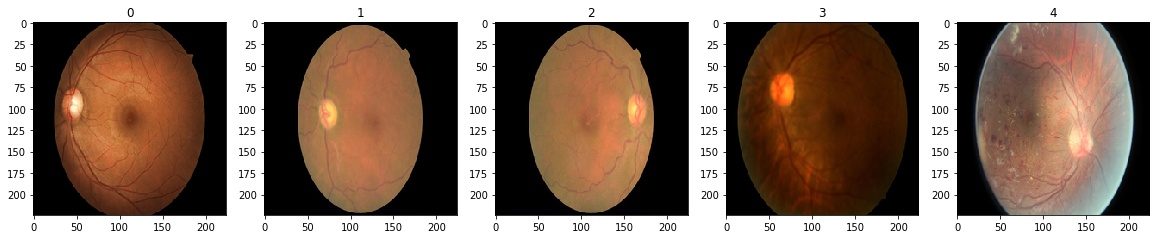

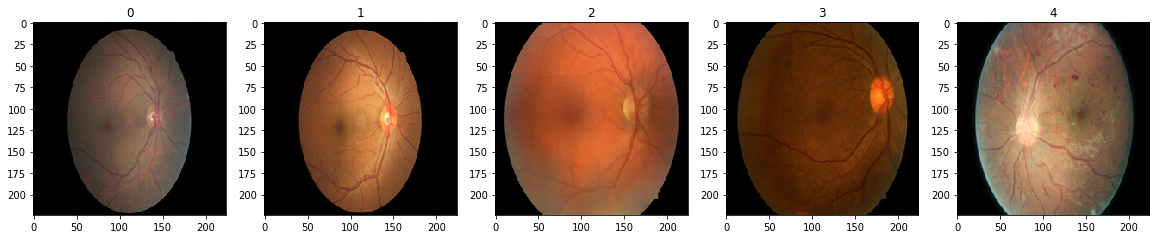

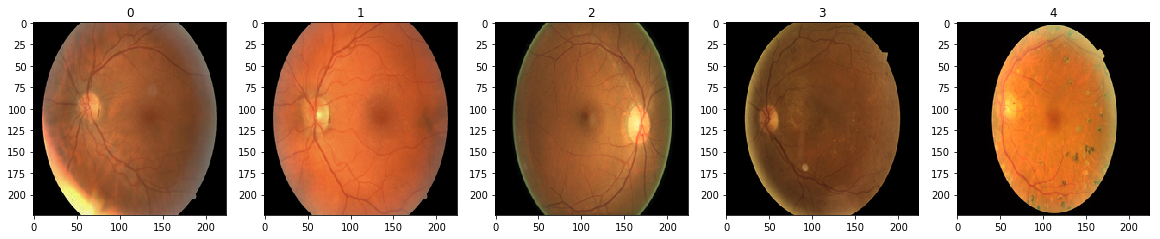

In [8]:
for i in range(3):
    plt.figure(figsize=(20, 20))
    for j in range(5):
        plt.subplot(1, 5, j+1)
        plt.imshow(preprocess_image(train_df[train_df['diagnosis']==j].reset_index().iloc[i]['path']))
        plt.title(j)

### Split dataset

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, stratify=y, random_state=seed)

In [20]:
x_val_arr = np.empty((x_val.shape[0], EN_size, EN_size, 3), dtype=np.uint8)

for i, row in tqdm(x_val.reset_index().iterrows(), total=len(x_val)):
    try:
        x_val_arr[i, :, :, :] = preprocess_image(row['path'])
    except:
        pass

100%|██████████| 3447/3447 [02:16<00:00, 25.30it/s]


In [21]:
train_df = pd.DataFrame(pd.concat([x_train, pd.DataFrame(y_train)], axis=1), columns=['path', 'diagnosis'])

### Create data generator

In [22]:
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.25,
        rotation_range=180,
        fill_mode='constant',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=.05,
        height_shift_range=.05
    )

train_generator = create_datagen().flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='diagnosis',
    target_size=(EN_size, EN_size),
    class_mode='raw',
    batch_size=batch_size,
    seed=seed,
    interpolation="lanczos",
    )

Found 19531 validated image filenames.


### Create Keras callback for QWK score

In [23]:
class QWK(Callback):

    def on_train_begin(self, logs={}):
        self.val_kappas = []
        
    def on_epoch_end(self, epoch, logs={}):
        x_val, y_val = self.validation_data[:2]
        
        y_pred = self.model.predict(x_val)
        
        coeff = [0.5, 1.5, 2.5, 3.5]

        for i, pred in enumerate(y_pred):
            if pred < coeff[0]:
                y_pred[i] = 0
            elif pred >= coeff[0] and pred < coeff[1]:
                y_pred[i] = 1
            elif pred >= coeff[1] and pred < coeff[2]:
                y_pred[i] = 2
            elif pred >= coeff[2] and pred < coeff[3]:
                y_pred[i] = 3
            else:
                y_pred[i] = 4

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

### Model: EfficientNet B5

In [10]:
effnet = efn.EfficientNetB5(
    weights=None,
    include_top=False,
    input_shape=(EN_size, EN_size, 3)
)

effnet.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

In [11]:
def build_model():
    
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation="elu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse', optimizer=Adam(lr=1e-4), metrics=['mse'])
    
    return model

In [12]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 28,523,771
Trainable params: 28,351,035
Non-trainable params: 172,736
_________________________________________________________________


### Training and evaluation of the model

In [ ]:
qwk = QWK()

history = model.fit_generator(
    train_generator,
    steps_per_epoch=x_train.shape[0] / batch_size,
    epochs=15,
    validation_data=(x_val_arr, y_val),
    callbacks=[qwk]
)

In [ ]:
model.load_weights('../input/effnetb5modelsubmission/model.h5')

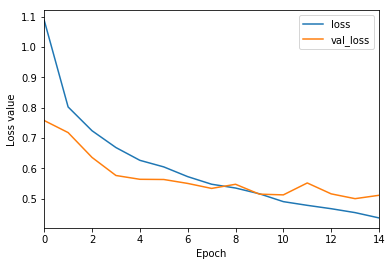

In [13]:
with open('../input/effnetb5historysubmission/history.json', 'r') as f:
    history = f.read()
history_df = pd.read_json(history)
ax = history_df[['loss', 'val_loss']].plot()
_ = ax.set_xlabel('Epoch')
_ = ax.set_ylabel('Loss value')

In [14]:
def predict_aptos(x_arr):
    
    y_pred = model.predict(x_arr)
    coeff = [0.5, 1.5, 2.5, 3.5]

    for i, pred in enumerate(y_pred):
        if pred < coeff[0]:
            y_pred[i] = 0
        elif pred >= coeff[0] and pred < coeff[1]:
            y_pred[i] = 1
        elif pred >= coeff[1] and pred < coeff[2]:
            y_pred[i] = 2
        elif pred >= coeff[2] and pred < coeff[3]:
            y_pred[i] = 3
        else:
            y_pred[i] = 4
    
    return y_pred

In [24]:
# Function to plot confusion matrices. Taken from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.GnBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

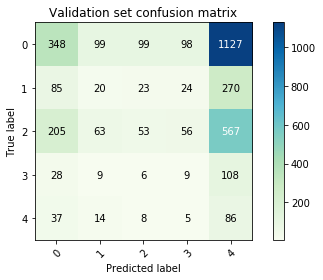

In [25]:
y_val_pred = predict_aptos(x_val_arr)

plot_confusion_matrix(y_val, y_val_pred, classes=np.array(['0', '1', '2', '3', '4']),
                      title='Validation set confusion matrix')

### Submission

In [26]:
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [17]:
N = test_df.shape[0]
x_test = np.empty((N, EN_size, EN_size, 3), dtype=np.uint8)

for i, img_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(f'../input/aptos2019-blindness-detection/test_images/{img_id}.png')

100%|██████████| 1928/1928 [01:42<00:00, 18.82it/s]


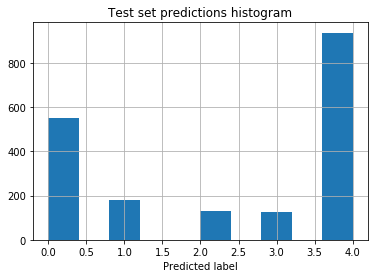

In [18]:
y_test = predict_aptos(x_test)

test_df['diagnosis'] = y_test.astype(int)
test_df.to_csv('submission.csv', index=False)

ax = test_df['diagnosis'].hist()
_ = ax.set_title('Test set predictions histogram')
_ = ax.set_xlabel('Predicted label')

### Saliency maps

In [ ]:
!pip install keras-vis
!pip install git+https://github.com/raghakot/keras-vis.git -U

from vis.utils import utils

layer_idx = utils.find_layer_idx(model, 'dense_2')
model.layers[layer_idx].activation

# visualize saliency maps

from vis.visualization import visualize_saliency
import scipy.ndimage as ndimage

#####

for i in range(1):
    plt.figure(figsize=(20, 20))
    lbl_idx = np.where(y_test == i)
    for j in range(1):
        img = x_test[lbl_idx[j], :, :, :]
        grads = visualize_saliency(model, layer_idx, filter_indices=None, seed_input=img, backprop_modifier=None, grad_modifier="absolute")
        gaus = ndimage.gaussian_filter(grads, sigma=5)
        plt.subplot(1, 5, j+1)
        plt.imshow(img)
        plt.imshow(gaus, alpha=.4)
        plt.title(i)